## Setup

In [1]:
import pandas as pd
import numpy as np
import re
import requests
from scipy.stats import poisson
import math
from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt
import json
import os
import string
import csv
from urllib.parse import quote_plus
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.corpus import PlaintextCorpusReader
from nltk import Text
from collections import defaultdict
import nltk, re, pprint
from nltk import word_tokenize
import community
import powerlaw
from tabulate import tabulate
from fa2 import ForceAtlas2
import wordcloud
from wordcloud import WordCloud
from nltk.probability import FreqDist
import operator
import wordcloud
from nltk.stem import WordNetLemmatizer
import matplotlib.image as mpimg
from community import community_louvain
import matplotlib.pyplot as plt
from collections import Counter
import random
%matplotlib inline

In [2]:
#set all plots to the same size and style
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

In [3]:
table_counter = 0
figure_counter = 0

# Part 0: Building the network

## Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.

**Answer:** 

Since we have already downloaded all rappers pages and a csv file with rappers distinguished by coasts, we go through each rapper in the csv file and find the correspondent wikipedia file. To do this we had to transform the name of the rapper to a readable format that coincide to the name of the file.

For each wikipedia file we search for the names inside brackets `[[  ]]`, which corresponds to the connections inside a wikipedia page (hyperlinks).

After getting the content between the brackets, we faced the problem of having inside the same bracket two names, the one with interest was the first that appeared. E.g.: ['Hip hop music|Hip hop'], we only want 'Hip hop music'. Those names are seperated by a `|` (pipe) symbol.

To get rid of all hyperlinks, which are not leading to another rapper, we check if the target of the hyperlink is in the rappers-list.

To make it easier for the peer grader, we are creating the network on our own again to be independent of the storagelocation.

## Show the regular expressions you have built and explain in details how they work.

 **Answer:**  
   
 The Regular Expression we have used is as follows: `r'\[\[(.*?)(?:\||\]\])'`

This regular expression is designed to match and capture text within double square brackets `[[ ]]`, stopping at the first occurrence of a pipe `|` or the closing double square brackets.

- `\[`: Matches a literal `[` character.
- `\[\[`: Matches the string `[[`.
- `(.*?)`: Captures any character (.) as few times as possible (*?), making a non-greedy match.
- `(?:\||\]\])`: A non-capturing group matching either a `|` character or the string `]]`.

[1]


# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

In [4]:
# Code to create the Network, extract the  largest connected component and save it as a file 
# we include this to show how we created the network, if someone wants to run notebook without having the files.

def get_wikipedia_content(title):
    baseurl = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "prop": "revisions",
        "rvprop": "content",
        "format": "json",
        "titles": title
    }
    response = requests.get(baseurl, params=params).json()
    page = next(iter(response["query"]["pages"].values()))
    content = page["revisions"][0]["*"]
    return content

def get_links_and_content(wikipedia_titles):
    links_dict = {}
    content_dict = {}
    for title in wikipedia_titles:
        content = get_wikipedia_content(title)
        links = re.findall(r'\[\[(.*?)(?:\||\]\])', content)
        links_dict[title] = links
        content_dict[title] = content
    return links_dict, content_dict

def build_graph(links_dict, all_rappers_set):
    G = nx.DiGraph()
    G.add_nodes_from(all_rappers_set)
    for rapper, links in links_dict.items():
        valid_links = set(links) & all_rappers_set
        G.add_edges_from((rapper, link) for link in valid_links)
    return G

EastCoast = pd.read_csv("EastCoastRappers.csv")
WestCoast = pd.read_csv("WestCoastRappers.csv")

toprapper_east = EastCoast.WikipediaPageName.tolist()
toprapper_west = WestCoast.WikipediaPageName.tolist()
all_rappers_set = set(toprapper_east + toprapper_west)

east_links_dict, east_content_dict = get_links_and_content(toprapper_east)
west_links_dict, west_content_dict = get_links_and_content(toprapper_west)

all_links_dict = {**east_links_dict, **west_links_dict}
all_content_dict = {**east_content_dict, **west_content_dict}

Graph_rapper = build_graph(all_links_dict, all_rappers_set)

largest_cc_rapper = max(nx.weakly_connected_components(Graph_rapper), key=len)
Graph_rapper_lcc = Graph_rapper.subgraph(largest_cc_rapper)

for node in Graph_rapper_lcc.nodes():
    Graph_rapper_lcc.nodes[node]["coast"] = "east" if node in toprapper_east else "west"
    Graph_rapper_lcc.nodes[node]["length"] = len(re.findall(r'\b\w+\b', all_content_dict[node]))
    Graph_rapper_lcc.nodes[node]["content"] = all_content_dict[node]

nx.write_gexf(Graph_rapper_lcc, "rapper_graph.gexf")

## Exercise 1a: Stats (see lecture 4 and 5 for more hints)

In [5]:
# Load the graph
G = nx.read_gexf("rapper_graph.gexf")

# 1. Number of nodes
num_nodes = G.number_of_nodes()

# 2. Number of links
num_links = G.number_of_edges()

# 3. Top connected rapper
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
top_rapper_in = max(in_degrees, key=in_degrees.get)
top_rapper_out = max(out_degrees, key=out_degrees.get)


# 4. Top 5 most connected east-coast rappers
east_coast_rappers = [n for n, d in G.nodes(data=True) if d['coast'] == 'east']
east_coast_in_degrees = {rapper: in_degrees[rapper] for rapper in east_coast_rappers}
east_coast_out_degrees = {rapper: out_degrees[rapper] for rapper in east_coast_rappers}
top_5_east_coast_in = sorted(east_coast_in_degrees, key=east_coast_in_degrees.get, reverse=True)[:5]
top_5_east_coast_out = sorted(east_coast_out_degrees, key=east_coast_out_degrees.get, reverse=True)[:5]

# 5. Top 5 most connected west-coast rappers
west_coast_rappers = [n for n, d in G.nodes(data=True) if d['coast'] == 'west']
west_coast_in_degrees = {rapper: in_degrees[rapper] for rapper in west_coast_rappers}
west_coast_out_degrees = {rapper: out_degrees[rapper] for rapper in west_coast_rappers}
top_5_west_coast_in = sorted(west_coast_in_degrees, key=west_coast_in_degrees.get, reverse=True)[:5]
top_5_west_coast_out = sorted(west_coast_out_degrees, key=west_coast_out_degrees.get, reverse=True)[:5]

# 6. Plot the in- and out-degree distributions
in_degree_values = sorted([d for n, d in G.in_degree()], reverse=True)
out_degree_values = sorted([d for n, d in G.out_degree()], reverse=True)

# 7. Find the exponent for the in- and out-degree distributions
fit_in = powerlaw.Fit(np.array(in_degree_values) + 1)
fit_out = powerlaw.Fit(np.array(out_degree_values) + 1)
exponent_in = fit_in.power_law.alpha
exponent_out = fit_out.power_law.alpha

# 8. Degree distribution of a random network
p = num_links / (num_nodes * (num_nodes - 1))
random_G = nx.erdos_renyi_graph(num_nodes, p)
random_degrees = sorted([d for n, d in random_G.degree()], reverse=True)

# Display the results
results = pd.DataFrame.from_dict({
    "Metric": ["Number of Nodes", "Number of Links", "Top Rapper (In-Degree)", "Top Rapper (Out-Degree)",
               "Top 5 East Coast Rappers (In-Degree)", "Top 5 East Coast Rappers (Out-Degree)",
               "Top 5 West Coast Rappers (In-Degree)", "Top 5 West Coast Rappers (Out-Degree)",
               "In-Degree Exponent", "Out-Degree Exponent"],
    "Value": [num_nodes, num_links, top_rapper_in, top_rapper_out,
              top_5_east_coast_in, top_5_east_coast_out,
              top_5_west_coast_in, top_5_west_coast_out,
              exponent_in, exponent_out]
})

Calculating best minimal value for power law fit
/Users/jonas/opt/anaconda3/envs/business_analytics/lib/python3.10/site-packages/powerlaw.py:698: RuntimeWarning: invalid value encountered in divide
  self.Asquare = sum(((CDF_diff**2) / (Theoretical_CDF * (1 - Theoretical_CDF)))[1:]
Calculating best minimal value for power law fit


In [6]:
# Sample table data
table_data = results

# Title and caption
table_counter += 1
caption = f"Table {table_counter}: Stats of Rapper network. Metrics in the left column and the actual value in the right column."

# Format the table using tabulate
table_str = tabulate(table_data, headers="keys", tablefmt="grid", showindex=False)

# Combine the title, table, and caption
labeled_table = f"{table_str}\n\n{caption}"

# Print or use labeled_table as needed
print(labeled_table)

+---------------------------------------+-------------------------------------------------------------------------+
| Metric                                | Value                                                                   |
+=======================================+=========================================================================+
| Number of Nodes                       | 728                                                                     |
+---------------------------------------+-------------------------------------------------------------------------+
| Number of Links                       | 5833                                                                    |
+---------------------------------------+-------------------------------------------------------------------------+
| Top Rapper (In-Degree)                | Snoop Dogg                                                              |
+---------------------------------------+-------------------------------

**What is the number of nodes in the network?**
  * The number of nodes in the network is **728**.

**What is the number of links?**
   * The number of links in the network is **5828**.

**Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?**
  * The top rapper based on in-degrees is **Snoop Dogg**.
  * The top rapper based on out-degrees is **Drag-On**.
  * Comment: Snoop Dogg being the top-connected rapper based on in-degrees is unsurprising given his big influence in the hip-hop industry. An explenation could be, that snoop dog is a role model for a lot of other rappers and therefore they are referencing to him . Drag-On being the top for out-degrees, indicating that he has the most links going out from his Wikipediapage. This could mean, that his Page is very detailed ord that he collaborated with a diverse range of artists and therefore names a lot of different artists.


**Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)?**
   * In-Degree: **Jay-Z, Nas, 50 Cent, Busta Rhymes, The Notorious B.I.G.**
   * Out-Degree: **Drag-On, Black Thought, MC Lyte, Jahlil Beats, DJ Premier**.


**Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?**
   * In-Degree: **Snoop Dogg, Dr. Dre, Kendrick Lamar, Tupac Shakur, E-40**.
   * Out-Degree: **DJ Dahi, The Game (rapper), Kendrick Lamar, Dr. Dre, Kurupt**.


**Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?**
   * In-Degree Exponent: **2.814131**.
   * Out-Degree Exponent: **12.091138**.
   * Comment: The exponents indicate the steepness of the decline in the number of nodes with a particular degree as the degree increases. Smaller exponent values suggest that there are more nodes with higher degrees. The observed values, especially for out-degrees, suggest a network that has a very skewed distribution, with few nodes having very high out-degrees.

* Plot the in- and out-degree distributions for the whole network.
  * Use axes that make sense for visualizing this particular distribution.
  * What do you observe? 
  * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?

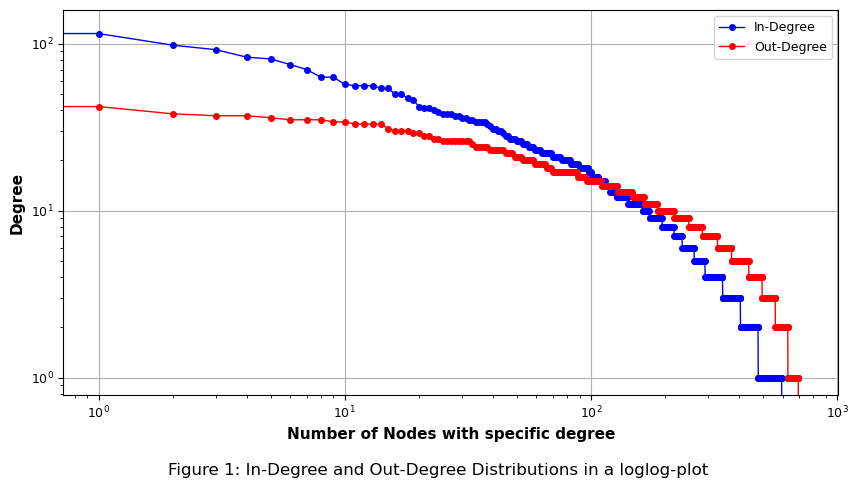

In [7]:
# plot the In-Degree and Out-Degree Distributions
plt.figure()
plt.loglog(in_degree_values, 'b-', marker='o', label='In-Degree')
plt.loglog(out_degree_values, 'r-', marker='o', label='Out-Degree')
plt.xlabel('Number of Nodes with specific degree')
plt.ylabel('Degree')
plt.legend()
figure_counter +=1
plt.figtext(0.5, -0.05, f"Figure {figure_counter}: In-Degree and Out-Degree Distributions in a loglog-plot", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


**Description of the plot**

The plots shows the in-degree and out-degree distributions. The in-degree and out-degree distributions follow a power-law distribution, which is common for many real-world networks. There is a small number of nodes (rappers) with high degrees, while most nodes have relatively low degrees.
Comparing the in and outgoing degrees, we can state that the number of incoming links is usually higher than the outgoing links. This could be explained by the lets call it 'rolemodel'-links. An less known rapper is stating that he got influenced by a very famous rapper and creates an incoming link for the famous rapper. Even though the famous rapper has maybe never heard about the less known rapper and therefore also no connection the less known rapper.
This could be also used to influence searching algorithms, because some one is trying to use as many as possible links to famous rapper to be more visible in in search engines.

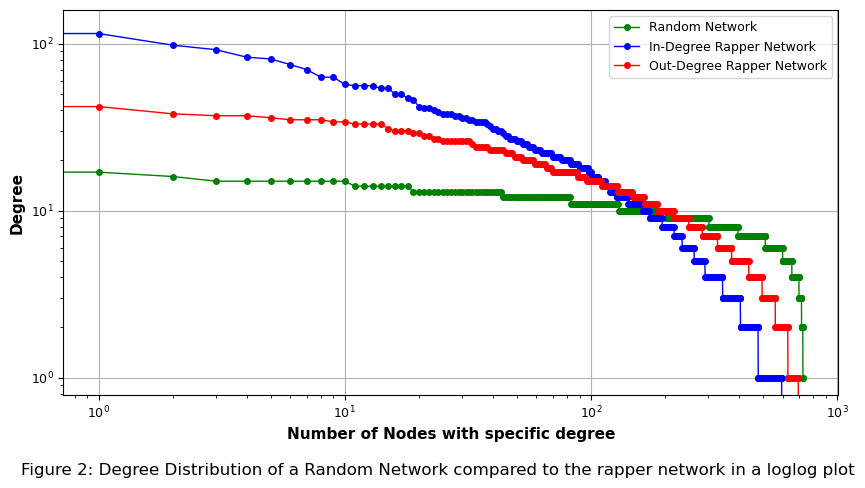

In [8]:
#plot the Degree Distribution of a Random Network like above
plt.figure()
plt.loglog(random_degrees, 'g-', marker='o', label='Random Network')
plt.loglog(in_degree_values, 'b-', marker='o', label='In-Degree Rapper Network')
plt.loglog(out_degree_values, 'r-', marker='o', label='Out-Degree Rapper Network')
plt.xlabel('Number of Nodes with specific degree')
plt.ylabel('Degree')
plt.legend()
figure_counter +=1
plt.figtext(0.5, -0.05, f"Figure {figure_counter}: Degree Distribution of a Random Network compared to the rapper network in a loglog plot", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


**Compare the two degree distributions to the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.**
  * The random network shows a more even distribution, suggesting that most nodes have a similar number of connections. This is in contrast to the observed power-law distributions for the in- and out-degrees in the rap network. The rap network has a few highly connected nodes, whereas in a random network, connections are more uniformly distributed. This showcases the uniqueness of real-world networks compared to theoretical random networks.

## Exercise 1b_: Visualization (see lecture 5 for more hints)

**Create a nice visualization of the total (directed) network:**
  * Color nodes according to the role;
  * Scale node-size according to degree;
  * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
  * Whatever else you feel like that would make the visualization nicer.
  * Describe the structure you observe. What useful information can you decipher from this?

In [9]:
# implement edge weight for G according to East and West Coast
for edge in G.edges():
    if G.nodes[edge[0]]['coast'] == G.nodes[edge[1]]['coast']:
        G.edges[edge]['weight'] = 1
    else:
        G.edges[edge]['weight'] = 0.01

In [10]:
#node color
node_colors = []


for key, value in nx.get_node_attributes(G, 'coast').items():
    if value == 'east':
        node_colors.append('blue')
    elif value == 'west':
        node_colors.append('red')
    else:
        node_colors.append('gray')


# node size 
node_sizes = [G.degree(node) * 1.5 for node in G.nodes()]

#color of the edge is based on the coast of the source node
edge_color_list = []
for edge in G.edges():
    if G.nodes[edge[0]]["coast"] == "west" and G.nodes[edge[1]]["coast"] == "west":
        edge_color_list.append("red")
    elif G.nodes[edge[0]]["coast"] == "east" and G.nodes[edge[1]]["coast"] == "east":
        edge_color_list.append("blue")
    else:
        edge_color_list.append("black")

#position
# create a ForceAtlas2 object
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=100.0,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=5.0,
                        strongGravityMode=True,
                        gravity=0.001,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None , iterations=1000)

#nx.draw_networkx_nodes(G, positions, node_size=node_sizes, node_color=node_colors, alpha=0.4)
#nx.draw_networkx_edges(G, positions, alpha=0.05, edge_color = edge_color_list)


100%|██████████| 1000/1000 [00:03<00:00, 285.00it/s]

BarnesHut Approximation  took  0.95  seconds
Repulsion forces  took  2.17  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.14  seconds


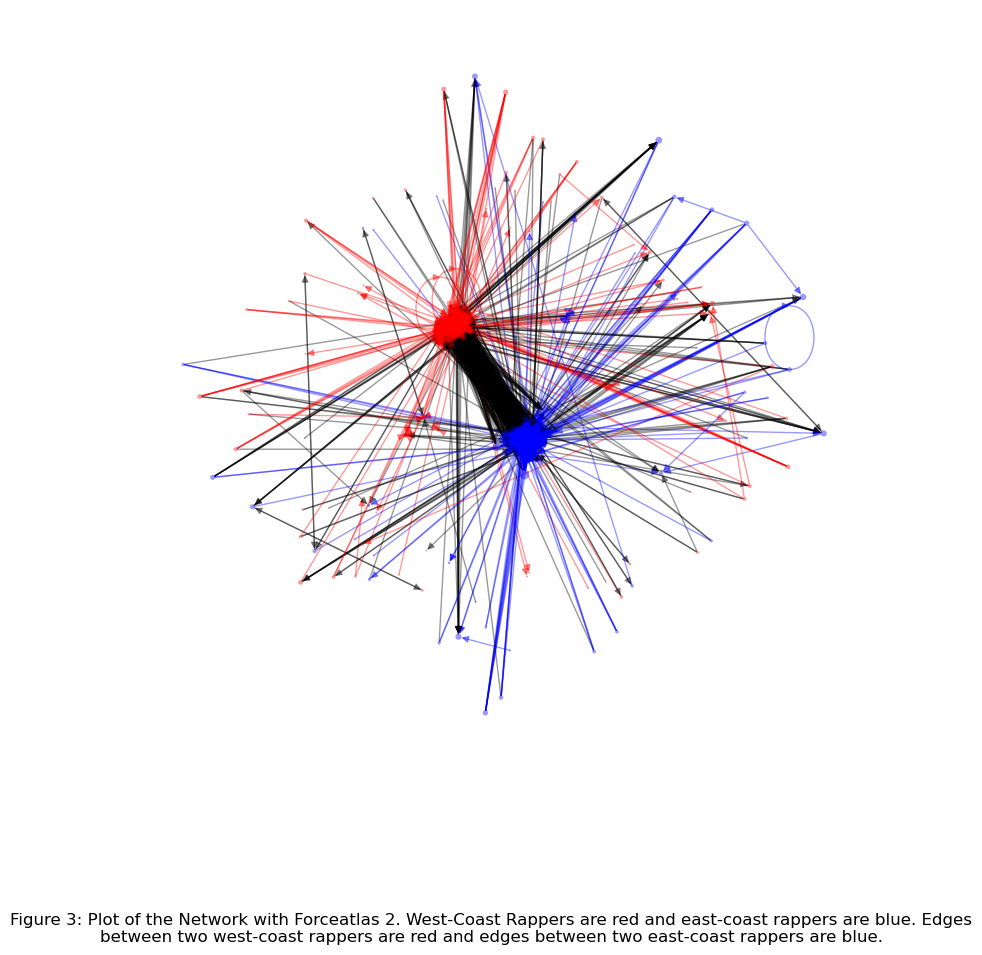

In [11]:
# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nx.draw_networkx(G, positions, node_size=node_sizes, node_color=node_colors, alpha=0.4, linewidths=0.1, edge_color = edge_color_list, ax=ax,with_labels=False)

figure_counter +=1
plt.figtext(0.5, -0.05, f"Figure {figure_counter}: Plot of the Network with Forceatlas 2. West-Coast Rappers are red and east-coast rappers are blue. Edges between two west-coast rappers are red and edges between two east-coast rappers are blue.", wrap=True, horizontalalignment='center', fontsize=12)
plt.axis('off')
plt.show() 

# Part 2: Word-clouds

## Data processing

**cleaning of the corpus**
- Remove all punctuation from your list of tokens

- Set everything to lower case

- Lemmatize your words

In [12]:
cwd = os.getcwd()
print('The east and westcoasttexts files, which are provided by Jonas have to be in the same folder as the notebook in order to execute the code.')
print('Your current working directory: '+cwd)

corpus_root_east = cwd +'/eastcoasttexts'

corpus_root_west = cwd +'/westcoasttexts'

#create new corpus only west coast

# delete all empty files in the dictonary
for filename in os.listdir(corpus_root_west):
    if os.path.getsize(corpus_root_west + '/' + filename) == 0:
        os.remove(corpus_root_west + '/' + filename)

for filename in os.listdir(corpus_root_east):
    if os.path.getsize(corpus_root_east + '/' + filename) == 0:
        os.remove(corpus_root_east + '/' + filename)

rapper_corpus_west = PlaintextCorpusReader(corpus_root_west, '.*\.txt')
rapper_text_west = Text(rapper_corpus_west.words())

rapper_corpus_east = PlaintextCorpusReader(corpus_root_east, '.*\.txt')
rapper_text_east = Text(rapper_corpus_east.words())

rapper_tokens_west = rapper_text_west.tokens
rapper_tokens_east = rapper_text_east.tokens

# Remove all punctuation from your list of tokens
punctuation = string.punctuation
rapper_tokens_west = [word for word in rapper_tokens_west if word not in punctuation]
rapper_tokens_east = [word for word in rapper_tokens_east if word not in punctuation]

# Set everything to lower case
rapper_tokens_west = [word.lower() for word in rapper_tokens_west]
rapper_tokens_east = [word.lower() for word in rapper_tokens_east]

# Lemmatize your words
wnl = WordNetLemmatizer()
rapper_tokens_west = [wnl.lemmatize(word) for word in rapper_tokens_west]
rapper_tokens_east = [wnl.lemmatize(word) for word in rapper_tokens_east]

with open('rapper_tokens_west.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(rapper_tokens_west)

with open('rapper_tokens_east.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(rapper_tokens_east)

The east and westcoasttexts files, which are provided by Jonas have to be in the same folder as the notebook in order to execute the code.
Your current working directory: /Users/jonas/Documents/DTU/SCAI/SocialGraphs_assignments


In [13]:
rapper_tokens_west = pd.read_csv('rapper_tokens_west.csv', header=None).iloc[0].tolist()
rapper_tokens_east = pd.read_csv('rapper_tokens_east.csv', header=None).iloc[0].tolist()

### Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
* Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
* For each coast, what are the 5 words with the highest TR scores? Comment on your result.

In [14]:
# count the frequency of each token in the text 

fdist_west = FreqDist(rapper_tokens_west)
fdist_east = FreqDist(rapper_tokens_east)

# make dict out of frequency distribution
freq_west = dict(fdist_west)
freq_east = dict(fdist_east)

In [15]:
# calculate a score for each word in east. The formular is (Tf_w)/(Tf_e + c)
# Tf_w = term frequency in west
# Tf_e = term frequency in east

n_factor = freq_west['the']/freq_east['the']

# create dict with score for each word
score_dict_east = {}
c = 1
for word in freq_east:
    if word in freq_west:
        score_dict_east[word] = (n_factor * freq_east[word])/(freq_west[word]+c)
    else:
        score_dict_east[word] = (n_factor * freq_east[word])/c


# create dict with score for each word
score_dict_west = {}
c = 1
for word in freq_west:
    if word in freq_east:
        score_dict_west[word] = (freq_west[word])/(n_factor * freq_east[word]+c)
    else:
        score_dict_west[word] = (freq_west[word])/c

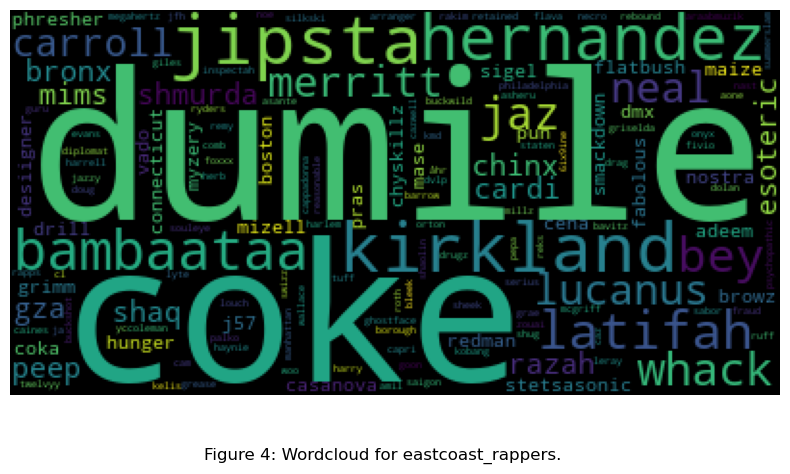

In [16]:
# Load the image
wordcloud = WordCloud()
score_dict_east = {str(k): v for k, v in score_dict_east.items()}

wordcloud.generate_from_frequencies(score_dict_east)
image = wordcloud.to_image()

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

plt.axis("off")
figure_counter +=1
plt.figtext(0.5, -0.02, f"Figure {figure_counter}: Wordcloud for eastcoast_rappers.", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

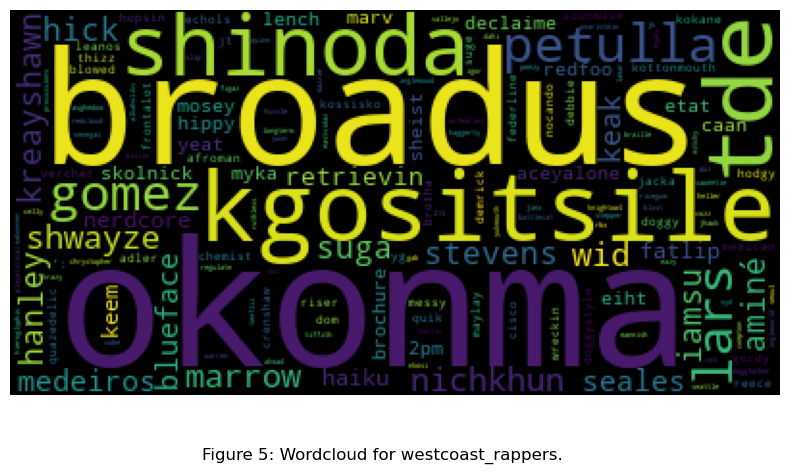

In [17]:
# Load the image
wordcloud = WordCloud()
score_dict_west = {str(k): v for k, v in score_dict_west.items()}
wordcloud.generate_from_frequencies(score_dict_west)
image = wordcloud.to_image()#
# Create a figure and axis
fig, ax = plt.subplots()#
# Display the image
ax.imshow(image)#
plt.axis("off")
figure_counter +=1
plt.figtext(0.5, -0.02, f"Figure {figure_counter}: Wordcloud for westcoast_rappers.", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [18]:
# sort dict by value

sorted_score_dict_east = sorted(score_dict_east.items(), key=operator.itemgetter(1), reverse=True)
sorted_score_dict_west = sorted(score_dict_west.items(), key=operator.itemgetter(1), reverse=True)

#print top 10 words
print(sorted_score_dict_east[:5])
print(sorted_score_dict_west[:5])

[('dumile', 60.28352543308717), ('coke', 53.71799296017669), ('kirkland', 47.74932707571261), ('jipsta', 47.74932707571261), ('hernandez', 46.854027193042995)]
[('okonma', 106.0), ('broadus', 84.0), ('kgositsile', 70.0), ('tde', 68.0), ('shinoda', 63.87509184423219)]


**East Coast:**
- **dumile**: 60.28 - MF DOOM, born Daniel Dumile, was a British-American rapper known for his intricate rhymes and unique style.
- **coke**: 53.72 - This might refer to drug references in his lyrics, a common theme in rap music, or it might be part of a name or term specific to this artist's life or work.
- **kirkland**: 47.75 - This might be a reference to something specific in MF DOOM's life or career.
- **jipsta**: 47.75 - This term is unclear and might require more context to interpret.
- **hernandez**: 46.85 - This could be a reference to a person or a place associated with MF DOOM.

**West Coast:**
- **okonma**: 106.0 - Tyler, The Creator's real name, suggesting a strong focus on his personal life and background in his Wikipedia page.
- **broadus**: 84.0 - Snoop Dogg's real last name, indicating a focus on his real identity in addition to his stage persona.
- **kgositsile**: 70.0 - Earl Sweatshirt's real name, pointing towards a personal focus in his Wikipedia page.
- **tde**: 68.0 - Top Dawg Entertainment, a record label known for signing West Coast artists. This suggests that the Wikipedia pages for these artists might discuss their professional affiliations and the music industry.
- **shinoda**: 63.88 - This might be an outlier or error, as Mike Shinoda is not typically associated with West Coast rap.

# Part 3: Communities

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 
> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?
> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.
> * Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

### In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it.

Modularity is a measuremt, which defines the quality of a partition in a network. A partition breaks the full network into n communities. The goal of modularity is to measure the strength of division of a network into communities.

We, use **equation 9.12** in the book _Network Science_  to calculate the modularity _M_ of the partition. 

$$ M = \sum_{c=1}^{n_c} \left[ \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right] \quad \text{[2]}$$


where:

- $M$ is the modularity of the entire network.
- $n_c$ is the number of communities (partitions) in the network.
- $L_c$ is the total number of links (edges) within community $c$.
- $L$ is the total number of links in the entire network.
- $k_c$ is the sum of the degrees of all nodes in community $c$.

**Explanation of the Formula**

- $\frac{L_c}{L}$: This term represents the fraction of links within community $c$. A high value indicates that a large portion of the links in the network are confined within this community, suggesting a strong community.
- $\left( \frac{k_c}{2L} \right)^2$: This term is the expected fraction of links within community $c$ if the links were distributed randomly, while preserving node degrees. The factor of 2 in the denominator normalizes the degree sum, as each link contributes to the degree of two nodes.
- $\frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2$: This difference measures how the actual fraction of links within the community compares to the expected fraction under a random distribution. A positive value indicates that there are more links within the community than expected by chance, suggesting a meaningful community structure.
- $\sum_{c=1}^{n_c}$: The modularity $M$ is the sum of these differences across all communities in the network. It ranges from -0.5 to 1, where higher values indicate a stronger community structure.


In essence:
M measures the density of links within communities as compared to links between communities. When the network's division into communities maximizes the number of intra-community links and minimizes the number of inter-community links, modularity will be high.

[3]

### Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?

We use the louvain method described in Fast unfolding of communities in large networks. [4]

The primary reason I chose this method is its ability to efficiently deal with large networks, and its reputation for uncovering hierarchical community structure with high modularity.

How does it work?

The Louvain method is a hierarchical agglomerative algorithm, which means it works by iteratively grouping nodes into communities in a way that maximizes the modularity of the network. The algorithm can be broken down into two primary steps:

1. Local Optimization: In this phase, the algorithm starts with each node in its own community. It then examines each node's neighbors to determine if moving that node to a neighboring community would increase the modularity. This process is repeated for all nodes until no such move can improve the modularity.  
2. Aggregation: Once the local optimization phase is completed, the algorithm treats each identified community as a "super-node" and aggregates them. Links between nodes in the same community are transformed into self-loops on the corresponding super-node. Links between different communities result in weighted edges between the corresponding super-nodes. This aggregated network is then used as the input for the next round of the local optimization phase.  
These two steps are repeated iteratively until there is no significant increase in modularity, resulting in a hierarchical structure of communities.



In [23]:
# Load the graph
G = nx.read_gexf("rapper_graph.gexf")

#set the seed to reproduce the results
partition = community_louvain.best_partition(G.to_undirected(), random_state=42)
modularity = community_louvain.modularity(partition, G.to_undirected())

print("Modularity of the whole graph after using the louvain heuristic: ", modularity)
print("Number of communities as best partition after using the louvain heuristic: ", max(partition.values()))

Modularity of the whole graph after using the louvain heuristic:  0.4148355380055209
Number of communities as best partition after using the louvain heuristic:  7


### Comment on your results

* **How many communities did you find in total?**
Over multiple runs of the Louvain algorithm (without a random state), the number of detected communities varied. We got results with the number of communities detected were 7,8,9 and 10. This demonstrates that the Louvain method can produce different partitions on different runs due to its heuristic nature.  
  
* **Compute the value of modularity with the partition created by the algorithm.**  
The computed modularity values for the respective runs were approximately between 0.4105, 0.4145, and 0.4231. These values suggest that the partitions found by the algorithm were quite good at separating the graph into communities such that intra-community edges are favored over inter-community edges. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


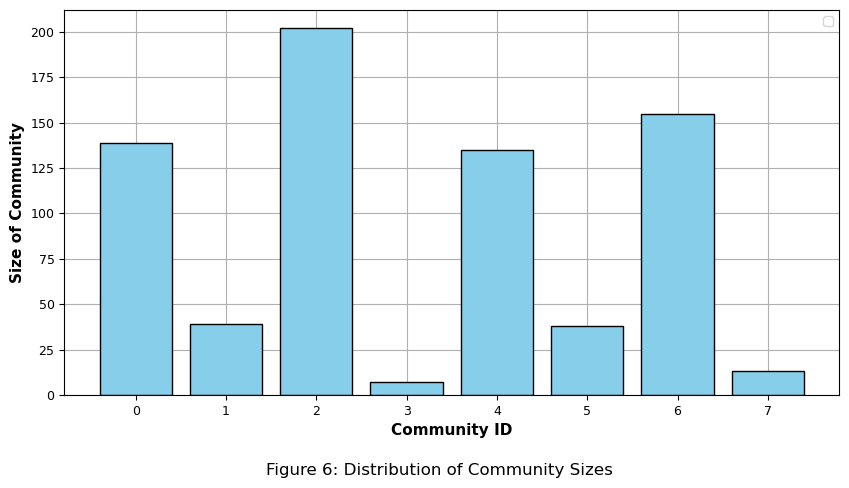

In [25]:
# Using the 'partition' you got from community_louvain.best_partition
community_sizes = Counter(partition.values())

# Extracting community IDs and their sizes
communities = list(community_sizes.keys())
sizes = list(community_sizes.values())

# Plotting
plt.figure()
plt.bar(communities, sizes, color='skyblue', edgecolor='black')
plt.xlabel('Community ID')
plt.ylabel('Size of Community')
plt.xticks(communities)
plt.legend()
figure_counter +=1
plt.figtext(0.5, -0.05, f"Figure {figure_counter}: Distribution of Community Sizes", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

community_sizes = pd.DataFrame(list(zip(communities, sizes)), columns =['Community ID', 'Size of Community'])
community_sizes = community_sizes.sort_values(by=['Community ID'])

In [27]:
community_sizes

,Community ID,Size of Community
0,0,139
1,1,39
2,2,202
7,3,7
3,4,135
4,5,38
5,6,155
6,7,13


**Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.**

1. Major Communities:
Community 2 is the largest, with 202 members. This indicates a very large and possibly diverse group, suggesting strong ties or commonalities among a significant portion of the rappers in this network.
Community 6 also represents a major community with 155 members, indicating another large subgroup within the network.
2. Medium-sized Communities:
Communities 0 and 4 are medium-sized, with 139 and 135 members respectively. These communities represent a balanced and substantial portion of the network, suggesting a moderate level of interconnection among their members.
Community 1, with 39 members, and Community 5, with 38 members, are on the smaller side of the medium scale but still represent notable subgroups within the network.
3. Smallest Communities:
Community 7 has 13 members, making it one of the smaller communities in the network. This could represent a niche group with very specific connections or commonalities.
Community 3 is the smallest community with only 7 members. This tiny community might represent a very tight-knit group, possibly connected by a very specific shared characteristic or location.
4. Variation in Community Sizes:
The sizes of the communities vary significantly, ranging from as few as 7 members in Community 3 to as many as 202 members in Community 2. This wide range suggests a heterogenous network structure with a mix of large, interconnected groups and smaller, more tightly-knit communities.

### Now, partition your rappers into two communities based on which coast they represent.

In [28]:
#get the undirected graph
Graph_undirected = G.to_undirected()

# make a dict. For every node, the dict contains the coast of the node. 0 = east, 1 = west
# this is our partition for the modularity calculation
partition_east_west = {}
for node in Graph_undirected.nodes():
    if Graph_undirected.nodes[node]["coast"] == "east":
        partition_east_west[node] = 0
    if Graph_undirected.nodes[node]["coast"] == "west":
        partition_east_west[node] = 1

# do this on our own

# number of communities 
n_c = 2 

m_east = 0
m_west = 0

# iterate through all edges in the graph
for node1, node2 in Graph_undirected.edges():
    # Check if the edge is within the east coast community
    if (Graph_undirected.nodes[node1]["coast"] == "east" and
        Graph_undirected.nodes[node2]["coast"] == "east"):
        m_east += 1
    # Check if the edge is within the west coast community
    elif (Graph_undirected.nodes[node1]["coast"] == "west" and
          Graph_undirected.nodes[node2]["coast"] == "west"):
        m_west += 1


#calculate the number of edges in the graph
m = Graph_undirected.number_of_edges()

# calculate the total degree of the nodes in east coast
k_east = 0
for node in Graph_undirected.nodes():
    if Graph_undirected.nodes[node]["coast"] == "east":
        for neighbor in Graph_undirected.neighbors(node):
            if Graph_undirected.nodes[neighbor]["coast"] == "east":
                k_east += 1

# calculate the total degree of the nodes in west coast
k_west = 0
for node in Graph_undirected.nodes():
    if Graph_undirected.nodes[node]["coast"] == "west":
        for neighbor in Graph_undirected.neighbors(node):
            if Graph_undirected.nodes[neighbor]["coast"] == "west":
                k_west += 1


modularity_own = (m_east/m) - ((k_east/(2*m))**2) + (m_west/m) - ((k_west/(2*m))**2)

print("Modularity ", modularity_own)

Modularity  0.44794666631367475


**What is the modularity of this partition? Comment on the result.**

1. Modularity with East-West Partition (0.4479):
Deviding the graph into two communities based on geographical criteria (east coast and west coast). A modularity score of 0.4479 indicates that there's a good degree of separation between these two communities compared to what one would expect if edges were placed randomly between nodes.

2. Modularity with Louvain Heuristic (~0.41):
The Louvain method is a popular heuristic for community detection in networks. The fact that the modularity score is ~0.41 with 7 to 9 partitions indicates that while the heuristic has identified more granular communities, the separation between these communities isn't as strong (in terms of modularity) as the geographical east-west separation.

In general the modularity with the Louvain Heuristic is lower, which could be due to the structure of the heurisic. However, it's essential to consider the real-world context and the nature of the data to sometimes find the best partitions. 

# Part 4: Sentiment of communities

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper




In [29]:
labmt=pd.read_csv('Data_Set_S1.txt', delimiter='\t')

In [30]:
def tokenize(text):
    tokens = word_tokenize(text)
    wnl = nltk.WordNetLemmatizer()
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [wnl.lemmatize(word) for word in tokens]
    return tokens

In [31]:
def sentiment(labmt,tokens):
    
    freq_dist = FreqDist(tokens)
    

    # Calculate sentiment scores for unique words
    sentiment_scores = {}
    
    for word, frequency in freq_dist.items():
        matching_word = labmt[labmt['word'] == word]

        if not matching_word.empty:
            sentiment = matching_word['happiness_average'].values[0]
            sentiment_scores[word] = sentiment

    total_sentiment = sum(sentiment_scores[word] * freq for word, freq in freq_dist.items() if word in sentiment_scores)
    total_frequency = sum(freq for word, freq in freq_dist.items() if word in sentiment_scores)
    
    average_sentiment = total_sentiment / total_frequency

     # Create a dictionary with words, frequencies, and happiness scores
    words_dict = {
        word: {
            'frequency': freq,
            'happiness_score': sentiment_scores[word]
        }
        for word, freq in freq_dist.items() if word in sentiment_scores
    }
  

    # Order words by happiness score
    words_dict = dict(sorted(words_dict.items(), key=lambda item: item[1]['happiness_score'], reverse=True))

    return average_sentiment, words_dict

In [32]:
G = nx.read_gexf('rapper_graph.gexf')

#Create more 2 nodes attributtes to save the average sentiment and the words present in their wikipedia pages, the freqeuncy and the score
for node in G.nodes():
 tokens  = tokenize(G.nodes[node]["content"])
 average_sentiment, words_dict = sentiment(labmt, tokens)
 G.nodes[node]["average_sentiment"] = average_sentiment
 G.nodes[node]["words_dict"] = words_dict

**Create a histogram of all rappers' associated sentiments.**


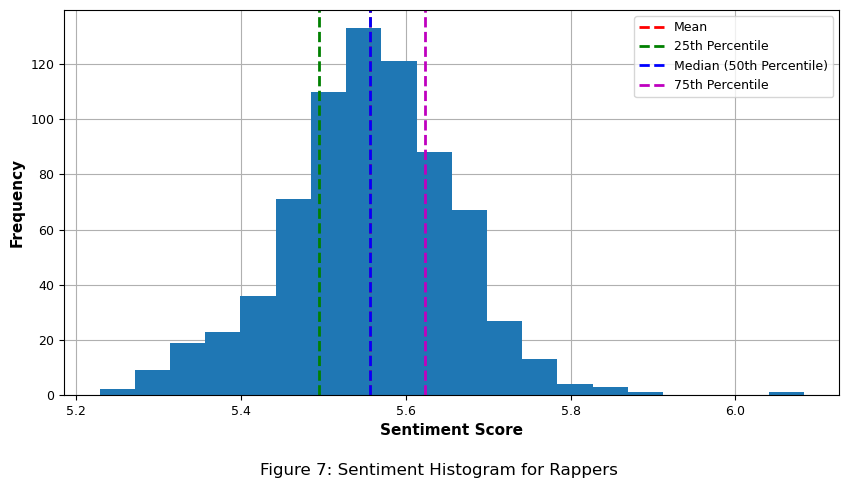

Mean Sentiment: 5.556234068283112
Percentiles:
25th Percentile: 5.495241767244253
50th Percentile (Median): 5.556768680470302
75th Percentile: 5.622942555476018


In [33]:
# Gather sentiments for all rappers
all_sentiments = [G.nodes[node]['average_sentiment'] for node in G.nodes()]

# Calculate the mean
mean_sentiment = np.mean(all_sentiments)

# Calculate percentiles (e.g., 25th, 50th, and 75th percentiles)
percentiles = np.percentile(all_sentiments, [25, 50, 75])

# Plot the histogram
plt.figure()
plt.hist(all_sentiments, bins=20)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Add vertical lines for mean and percentiles
plt.axvline(mean_sentiment, color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(percentiles[0], color='g', linestyle='dashed', linewidth=2, label='25th Percentile')
plt.axvline(percentiles[1], color='b', linestyle='dashed', linewidth=2, label='Median (50th Percentile)')
plt.axvline(percentiles[2], color='m', linestyle='dashed', linewidth=2, label='75th Percentile')

plt.legend()
figure_counter +=1
plt.figtext(0.5, -0.05, f"Figure {figure_counter}: Sentiment Histogram for Rappers", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

print(f"Mean Sentiment: {mean_sentiment}")
print("Percentiles:")
print(f"25th Percentile: {percentiles[0]}")
print(f"50th Percentile (Median): {percentiles[1]}")
print(f"75th Percentile: {percentiles[2]}")

Description Figure: The Histogram represents the distribution of average hapiness score of all rapper's (west and east coast) wikipedia pages. We can see that the majority of the pages have score between 5.5 and 5.6 (as indicated by the 25th and 75th percentiles), this means that rappers in general have a slightly positive sentiment on average in their Wipedia pages (in the the dictionary labMT we have as lower score 1.3 and higher 8.5)

**What are the 10 rappers with happiest and saddest pages?**

In [34]:
# Create lists to store data for happiest and saddest rappers
happiest_rapper_names = []
happiest_positive_words = []
happiest_positive_frequencies = []
happiest_positive_scores = []
happiest_negative_words = []
happiest_negative_frequencies = []
happiest_negative_scores = []
happiest_overall_scores = []
happiest_text_lengths = []

saddest_rapper_names = []
saddest_positive_words = []
saddest_positive_frequencies = []
saddest_positive_scores = []
saddest_negative_words = []
saddest_negative_frequencies = []
saddest_negative_scores = []
saddest_overall_scores = []
saddest_text_lengths = []

# Find the 10 rappers with happiest and saddest pages
sorted_rappers = sorted(G.nodes(data=True), key=lambda x: x[1]['average_sentiment'], reverse=True)
happiest_rappers = sorted_rappers[:10]
saddest_rappers = sorted_rappers[-10:]

# Extract data for the summary tables
for rapper in happiest_rappers:
    rapper_name = rapper[0]
    rapper_data = rapper[1]

    positive_word_data = sorted(rapper_data['words_dict'].items(), key=lambda x: x[1]['happiness_score'], reverse=True)[:3]
    negative_word_data = sorted(rapper_data['words_dict'].items(), key=lambda x: x[1]['happiness_score'])[:3]

    happiest_rapper_names.append(rapper_name)
    happiest_positive_words.append([word for word, _ in positive_word_data])
    happiest_positive_frequencies.append([info['frequency'] for _, info in positive_word_data])
    happiest_positive_scores.append([info['happiness_score'] for _, info in positive_word_data])
    happiest_negative_words.append([word for word, _ in negative_word_data])
    happiest_negative_frequencies.append([info['frequency'] for _, info in negative_word_data])
    happiest_negative_scores.append([info['happiness_score'] for _, info in negative_word_data])

    # Add the overall average sentiment for the happiest rapper
    happiest_overall_scores.append(rapper_data['average_sentiment'])
    
    # Add text length as a node attribute
    happiest_text_lengths.append(rapper_data['length'])

for rapper in saddest_rappers:
    rapper_name = rapper[0]
    rapper_data = rapper[1]

    positive_word_data = sorted(rapper_data['words_dict'].items(), key=lambda x: x[1]['happiness_score'], reverse=True)[:3]
    negative_word_data = sorted(rapper_data['words_dict'].items(), key=lambda x: x[1]['happiness_score'])[:3]

    saddest_rapper_names.append(rapper_name)
    saddest_positive_words.append([word for word, _ in positive_word_data])
    saddest_positive_frequencies.append([info['frequency'] for _, info in positive_word_data])
    saddest_positive_scores.append([info['happiness_score'] for _, info in positive_word_data])
    saddest_negative_words.append([word for word, _ in negative_word_data])
    saddest_negative_frequencies.append([info['frequency'] for _, info in negative_word_data])
    saddest_negative_scores.append([info['happiness_score'] for _, info in negative_word_data])

    # Add the overall average sentiment for the saddest rapper
    saddest_overall_scores.append(rapper_data['average_sentiment'])
    
    # Add text length as a node attribute
    saddest_text_lengths.append(rapper_data['length'])

# Create tables for happiest and saddest rappers
happiest_rappers_table = pd.DataFrame({
    'Rapper': happiest_rapper_names,
    'Positive Words': happiest_positive_words,
    'Positive Frequencies': happiest_positive_frequencies,
    'Positive Scores': happiest_positive_scores,
    'Negative Words': happiest_negative_words,
    'Negative Frequencies': happiest_negative_frequencies,
    'Negative Scores': happiest_negative_scores,
    'Overall Average Sentiment': happiest_overall_scores,
    'Text Length': happiest_text_lengths
})

saddest_rappers_table = pd.DataFrame({
    'Rapper': saddest_rapper_names,
    'Positive Words': saddest_positive_words,
    'Positive Frequencies': saddest_positive_frequencies,
    'Positive Scores': saddest_positive_scores,
    'Negative Words': saddest_negative_words,
    'Negative Frequencies': saddest_negative_frequencies,
    'Negative Scores': saddest_negative_scores,
    'Overall Average Sentiment': saddest_overall_scores,
    'Text Length': saddest_text_lengths
})

In [35]:
# Sample table data
table_data = happiest_rappers_table

# Title and caption
table_counter +=1
caption = f"Table {table_counter}:  Top 10 Happiest Rappers"

# Format the table using tabulate
table_str = tabulate(table_data, headers="keys", tablefmt="grid", showindex=True)

# Combine the title, table, and caption
labeled_table = f"{table_str}\n\n{caption}"

# Print or use labeled_table as needed
print(labeled_table)

+----+-------------------+-----------------------------------------+------------------------+--------------------+-------------------------------------+------------------------+--------------------+-----------------------------+---------------+
|    | Rapper            | Positive Words                          | Positive Frequencies   | Positive Scores    | Negative Words                      | Negative Frequencies   | Negative Scores    |   Overall Average Sentiment |   Text Length |
+====+===================+=========================================+========================+====================+=====================================+========================+====================+=============================+===============+
|  0 | Phil Da Agony     | ['strong', 'musician', 'living']        | [1, 1, 1]              | [7.06, 6.98, 6.68] | ['category', 'arm', 'hop']          | [2, 1, 1]              | [5.42, 5.5, 5.6]   |                     6.08333 |            13 |
+----+--------------

In [36]:
# Sample table data
table_data = saddest_rappers_table

# Title and caption
table_counter +=1
caption = f"Table {table_counter}:  Top 10 Saddest Rappers"

# Format the table using tabulate
table_str = tabulate(table_data, headers="keys", tablefmt="grid", showindex=True)

# Combine the title, table, and caption
labeled_table = f"{table_str}\n\n{caption}"

# Print or use labeled_table as needed
print(labeled_table)

+----+-------------------+-------------------------------+------------------------+--------------------+-------------------------------+------------------------+--------------------+-----------------------------+---------------+
|    | Rapper            | Positive Words                | Positive Frequencies   | Positive Scores    | Negative Words                | Negative Frequencies   | Negative Scores    |   Overall Average Sentiment |   Text Length |
+====+===================+===============================+========================+====================+===============================+========================+====================+=============================+===============+
|  0 | Cool C            | ['love', 'music', 'rich']     | [2, 1, 2]              | [8.42, 8.02, 7.98] | ['murder', 'death', 'killed'] | [10, 11, 2]            | [1.48, 1.54, 1.56] |                     5.29739 |          2066 |
+----+-------------------+-------------------------------+------------------------+-

Happier Rappers Statistics:
Mean: 5.82
Median: 5.72
25th Percentile: 5.22
75th Percentile: 6.34


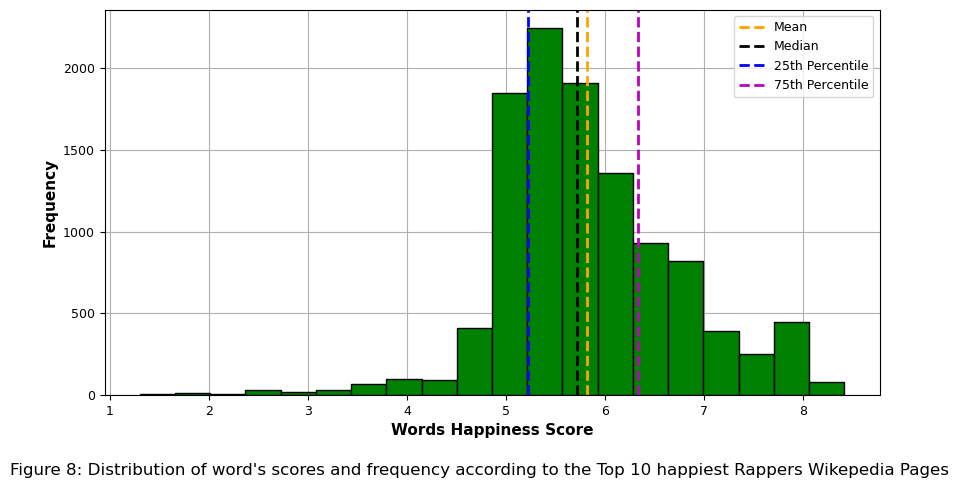


Sadder Rappers Statistics:
Mean: 5.27
Median: 5.3
25th Percentile: 4.98
75th Percentile: 5.78


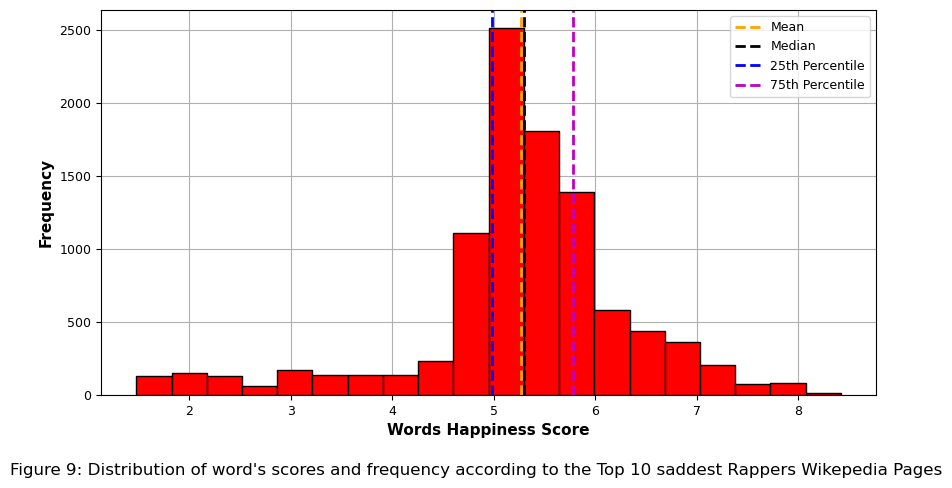

In [37]:
happy_scores = []

# Iterate through the rappers and their word dictionaries
for rapper in happiest_rappers:
    words_dict = rapper[1]['words_dict']
    for word, word_data in words_dict.items():
        happiness_score = word_data['happiness_score']
        frequency = word_data['frequency']
        happy_scores.extend([happiness_score] * frequency)


sad_scores = []


# Iterate through the rappers and their word dictionaries
for rapper in saddest_rappers:
    words_dict = rapper[1]['words_dict']
    for word, word_data in words_dict.items():
        happiness_score = word_data['happiness_score']
        frequency = word_data['frequency']
        sad_scores.extend([happiness_score] * frequency)




# Calculate the mean, median, and percentiles for happy_scores and sad_scores
mean_happy = round(np.mean(happy_scores),2)
median_happy = np.median(happy_scores)
percentiles_happy = np.percentile(happy_scores, [25, 75])

mean_sad = round(np.mean(sad_scores),2)
median_sad = np.median(sad_scores)
percentiles_sad = np.percentile(sad_scores, [25, 75])

# Print the statistics for happier rappers
print("Happier Rappers Statistics:")
print(f"Mean: {mean_happy}")
print(f"Median: {median_happy}")
print(f"25th Percentile: {percentiles_happy[0]}")
print(f"75th Percentile: {percentiles_happy[1]}")

# Plot the histogram
plt.figure()
plt.hist(happy_scores, bins=20, edgecolor='black', color='green')
plt.xlabel("Words Happiness Score")
plt.ylabel("Frequency")

# Add vertical lines for mean, median, and percentiles for happy_scores
plt.axvline(mean_happy, color='orange', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_happy, color='black', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(percentiles_happy[0], color='b', linestyle='dashed', linewidth=2, label='25th Percentile')
plt.axvline(percentiles_happy[1], color='m', linestyle='dashed', linewidth=2, label='75th Percentile')

plt.legend()
figure_counter +=1
plt.figtext(0.5, -0.05, f"Figure {figure_counter}: Distribution of word's scores and frequency according to the Top 10 happiest Rappers Wikepedia Pages", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()



# Print the statistics for sadder rappers
print("\nSadder Rappers Statistics:")
print(f"Mean: {mean_sad}")
print(f"Median: {median_sad}")
print(f"25th Percentile: {percentiles_sad[0]}")
print(f"75th Percentile: {percentiles_sad[1]}")

# Plot the histogram
plt.figure()
plt.hist(sad_scores, bins=20, edgecolor='black', color='red')
plt.xlabel("Words Happiness Score")
plt.ylabel("Frequency")

# Add vertical lines for mean, median, and percentiles for sad_scores
plt.axvline(mean_sad, color='orange', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_sad, color='black', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(percentiles_sad[0], color='b', linestyle='dashed', linewidth=2, label='25th Percentile')
plt.axvline(percentiles_sad[1], color='m', linestyle='dashed', linewidth=2, label='75th Percentile')

plt.legend()
figure_counter +=1
plt.figtext(0.5, -0.05, f"Figure {figure_counter}: Distribution of word's scores and frequency according to the Top 10 saddest Rappers Wikepedia Pages", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

**Answer**:

The sentiment analysis results categorize rappers into "happiest" and "saddest" based on the emotional tone of their pages. The happiest rappers, like Phil Da Agony, have pages with more positive language, resulting in higher average sentiment scores. The saddest rappers, such as Ol' Dirty Bastard, have pages with more negative language, leading to lower average sentiment scores. Tables provide a detailed breakdown of the specific positive and negative words contributing to these scores. This analysis quantitatively reflects the emotional tone associated with each rapper based on their page content.

**Now, compute the sentiment of each coast: 
Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).**


In [38]:
# Calculate the average sentiment for each coast
average_sentiments_west = []
average_sentiments_east = []

for node in G.nodes():
    sentiment = G.nodes[node]['average_sentiment']
    coast = G.nodes[node]['coast']
    
    if sentiment != 0:  # Disregard rappers with sentiment 0
        if coast == 'west':
            average_sentiments_west.append(sentiment)
        elif coast == 'east':
            average_sentiments_east.append(sentiment)

# Determine the happiest and saddest coast
west_sentiment=np.mean(average_sentiments_west)
east_sentiment=np.mean(average_sentiments_east)

happiest_coast = 'west coast' if west_sentiment > east_sentiment else 'east coast'


# Print the results
print(f'West sentiment: {west_sentiment}')
print(f'East sentiment: {east_sentiment}')
print(f'So in this case the happiest coast is: {happiest_coast}')

West sentiment: 5.55858201016612
East sentiment: 5.554502531190394
So in this case the happiest coast is: west coast


**Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
Does the result make sense to you? Elaborate.**

In [39]:
### Setting Up Variables:
if happiest_coast=='west coast':
    num_happiest_coast_rappers=len(average_sentiments_west)
else:
    num_happiest_coast_rappers=len(average_sentiments_east)


num_samples = 1000

all_sentiments = [data['average_sentiment'] for _, data in G.nodes(data=True) if 'average_sentiment' in data and data['average_sentiment'] != 0]  # All non-zero sentiments in the graph


### Running the Label Shuffling Test:
if happiest_coast=='west coast':
    average_sentiments_happiest_coast=west_sentiment
else:
    average_sentiments_happiest_coast=east_sentiment


count = 0
for _ in range(num_samples):
    random_sentiments = random.sample(all_sentiments, num_happiest_coast_rappers)
    if sum(random_sentiments) / len(random_sentiments) > average_sentiments_happiest_coast:
        count += 1

### Calculating and Interpreting the P-value:

p_value = count / num_samples
print(f"P-value: {p_value}")

P-value: 0.305


**Answer**:  
  
Hypotheses:

* Null Hypothesis (H0): The observed higher average sentiment for the happiest coast's rappers is due to random chance. There is no significant difference in the average sentiment of rappers' Wikipedia pages between the happiest coast and a randomly selected group of rappers of the same size.    
* Alternative Hypothesis (H1): The happiest coast's rappers have a significantly higher average sentiment on their Wikipedia pages compared to a randomly selected group of rappers of the same size.  

Results:  

P-value: 0.305  
The computed p-value was found to be greater than the significance level of 0.05.

Interpretation:

Given that our p-value is greater than 0.05, we fail to reject the null hypothesis. This indicates that we do not have sufficient statistical evidence to assert that the happiest coast's rappers have a significantly higher average sentiment on their Wikipedia pages compared to a randomly selected group of rappers of the same size, in other words we cannot confirm that the rappers of the west coast (happiest coast) are more happier compared to the other rappers. The observed difference in sentiments could plausibly have arisen due to random sampling variability.



# References

[1] Python Regular Expressions. Accessed: Oct. 30, 2023. [Online]. Available: https://developers.google.com/edu/python/regular-expressions            
[2] Network Science by Albert-László Barabási - Chapter 9: equation (9.12). Accessed: Oct. 30, 2023. [Online]. Available: http://networksciencebook.com/  
[3] Network Science by Albert-László Barabási - Chapter 9.4 . Accessed: Oct. 30, 2023. [Online]. Available: http://networksciencebook.com/  
[4] Aynaud, Thomas. "Community detection for NetworkX’s documentation." (2018).